In [120]:
import numpy as np
import pandas as pd
from hep_ml import reweight
from matplotlib import pyplot as plt
import uproot

In [121]:
columns = ["piminus_PT","gamma_PT","B_FD_OWNPV","piminus_IP_OWNPV"]
path = "/Users/finnjohnonori/Documents/GitHubRepositories/HistogramsLHCbFull/data/"


with uproot.open(path + "kpiG_MC_Bd2KstGamma_HighPt_prefilter_2018_noPIDsel-magup.root") as original_file: # type: ignore
        original_tree = original_file["DecayTree"]
        Kpi_up_MC_df = original_tree.arrays(columns, library='pd') # type: ignore

with uproot.open(path + "kpiG_MC_Bd2KstGamma_HighPt_prefilter_2018_noPIDsel-magdown.root") as Kpi_TChain_MC_down: # type: ignore
        Kpi_TTree_MC_down    = Kpi_TChain_MC_down["DecayTree"]
        Kpi_down_MC_df       = Kpi_TTree_MC_down.arrays(columns, library="pd") # type: ignore


original = pd.concat((Kpi_up_MC_df,Kpi_down_MC_df))
        
with uproot.open(path + "Sample_Kpigamma_2018_selectedTree_with_sWeights_Analysis_2hg_Unbinned-Mask1.root") as target_file: # type: ignore
        target_tree = target_file["DecayTree"]
        target = target_tree.arrays(columns + ["NB0_Kpigamma_sw"],library="pd", cut = "(abs(B_M01-895.55)<100)") # type: ignore




In [122]:
from sklearn.model_selection import train_test_split

# divide original samples into training ant test parts
original_train, original_test = train_test_split(original)
# divide target samples into training ant test parts
target_train, target_test = train_test_split(target)

original_weights_train = np.ones(len(original_train))
original_weights_test = np.ones(len(original_test))


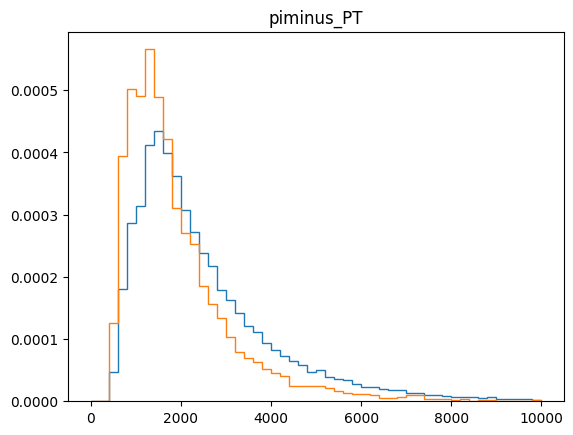

In [123]:
from hep_ml.metrics_utils import ks_2samp_weighted

hist_settings = {"bins" : 50, "density" : True, "alpha" : 1, "histtype" : "step"}


var = "piminus_PT"
plt.hist(original_test[var], weights=original_weights_test, range=(0,10000), **hist_settings)
plt.hist(target_test[var], weights=target_test["NB0_Kpigamma_sw"], range=(0,10000), **hist_settings)
plt.title(var)
plt.show()


In [124]:
print(f"Original train shape: {original_train.shape}")
print(f"Target train shape: {target_train[columns].shape}")
print(f"Original weights train shape: {original_weights_train.shape}")
print(f"Original weights test shape: {original_weights_test.shape}")


Original train shape: (158013, 4)
Target train shape: (110877, 4)
Original weights train shape: (158013,)
Original weights test shape: (52671,)


In [125]:
bins_reweighter = reweight.BinsReweighter(n_bins=20, n_neighs=1.)
bins_reweighter.fit(original_train, target_train[columns], original_weight = original_weights_train, target_weight= target_train["NB0_Kpigamma_sw"]  )

BinsReweighter(n_bins=20, n_neighs=1.0)

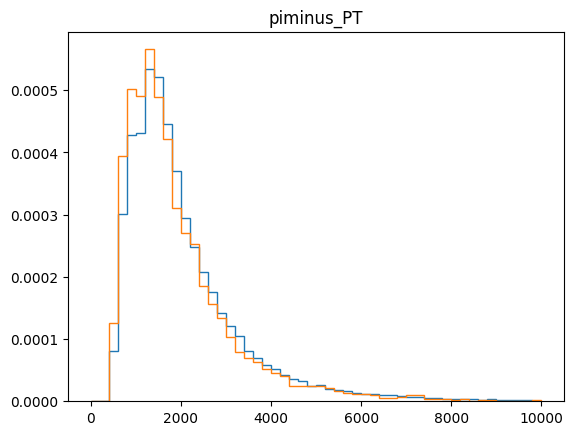

In [129]:
trained_weights_test = bins_reweighter.predict_weights(original_test)



var = "piminus_PT"
plt.hist(original_test[var], weights=trained_weights_test, range=(0,10000), **hist_settings)
plt.hist(target_test[var], weights=target_test["NB0_Kpigamma_sw"], range=(0,10000),**hist_settings)
plt.title(var)



In [ ]:


def createDoublePlot(variable):


    canvas, ((dist_original, dist_trained),(rati_original, rati_trained) ) = plt.subplots(2,2, gridspec_kw={"height_ratios" : [2,1] })
    canvas.tight_layout()

    #plot original histograms
    hist_kpi_y,   hist_kpi_x,   _  = dist_original.hist(dataframes["kpi"  ][variable], color=colors["kpi"  ], label="kpi MC",   **hist_style)
    hist_kpisw_y, hist_kpisw_x, _  = dist_original.hist(dataframes["kpisw"][variable], color=colors["kpisw"], label="Kpi Sample", **hist_style)

    dist_original.legend()

    ratio_data = np.nan_to_num( (hist_kpisw_y / hist_kpi_y), nan=0.0 )

    rati_original.scatter(hist_kpisw_x[:-1],ratio_data, s=1, c=colors["ratio"])
    rati_original.grid(axis="x", linestyle="dashed", alpha=0.7)
    dist_original.grid(axis="x", linestyle="dashed", alpha=0.7)

    hist_total_y = np.concatenate( (hist_kpi_y, hist_kpisw_y))
    hist_total_x = np.concatenate( (hist_kpi_x, hist_kpisw_x))
    dist_original.set_xlim(float("%.2g" % min(hist_total_x)), float("%.2g" % max(hist_total_x)))
    rati_original.set_xlim(float("%.2g" % min(hist_total_x)), float("%.2g" % max(hist_total_x)))
    dist_original.set_ylim(0, float("%.2g" % max(hist_total_y*1.1)))
    rati_original.set_ylim(0, max(ratio_data)*1.1)

    dist_original.set_ylabel("Distribution")
    rati_original.set_ylabel("Ratio")
    rati_original.set_xlabel(variable + " Original")

    #Train the weights
    bins_reweighter = reweight.BinsReweighter(n_bins=20, n_neighs=1.)
    bins_reweighter.fit(original_train, target_train[columns], original_weight = original_weights_train, target_weight = target_train["NB0_Kpigamma_sw"]  )
    trained_weights = bins_reweighter.predict_weights(dataframes["kpi"])


    #Plot trained histograms
    hist_kpi_y,   hist_kpi_x,   _  = dist_trained.hist(dataframes["kpi"  ][variable], color=colors["kpi"  ], weights=trained_weights, label="kpi MC",   **hist_style)
    hist_kpisw_y, hist_kpisw_x, _  = dist_trained.hist(dataframes["kpisw"][variable], color=colors["kpisw"], label="Kpi Sample", **hist_style)

    dist_trained.legend()

    ratio_data = np.nan_to_num( (hist_kpisw_y / hist_kpi_y), nan=0.0 )

    rati_trained.scatter(hist_kpisw_x[:-1],ratio_data, s=1, c=colors["ratio"])
    rati_trained.grid(axis="x", linestyle="dashed", alpha=0.7)
    dist_trained.grid(axis="x", linestyle="dashed", alpha=0.7)

    hist_total_y = np.concatenate( (hist_kpi_y, hist_kpisw_y))
    hist_total_x = np.concatenate( (hist_kpi_x, hist_kpisw_x))
    
    dist_trained.set_xlim(float("%.2g" % min(hist_total_x)), float("%.2g" % max(hist_total_x)))
    rati_trained.set_xlim(float("%.2g" % min(hist_total_x)), float("%.2g" % max(hist_total_x)))
    dist_trained.set_ylim(0, float("%.2g" % max(hist_total_y*1.1)))
    rati_trained.set_ylim(0, max(ratio_data)*1.1)


    rati_trained.set_xlabel(variable + " Trained")


createDoublePlot("piminus_PT")
